# Audio to PPG

Clone Repo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/IAmNelu/DeepVoiceSP.git
%cd DeepVoiceSP/

Cloning into 'DeepVoiceSP'...
remote: Enumerating objects: 380, done.
remote: Counting objects: 100% (380/380), done.
remote: Compressing objects: 100% (259/259), done.
remote: Total 380 (delta 238), reused 258 (delta 119), pack-reused 0
Receiving objects: 100% (380/380), 108.93 KiB | 1.41 MiB/s, done.
Resolving deltas: 100% (238/238), done.
/content/DeepVoiceSP


In [3]:
!mkdir checkpoints
!unzip ../drive/MyDrive/Voice_Conversion_SP/checkpoints/mfcc2ppg.zip -d  checkpoints

Archive:  ../drive/MyDrive/Voice_Conversion_SP/checkpoints/mfcc2ppg.zip
  inflating: checkpoints/mfcc2ppg.ckpt.data-00000-of-00001  
  inflating: checkpoints/mfcc2ppg.ckpt.index  


In [4]:
!pip -q install pydub
!pip -q install pysptk 

     |████████████████████████████████| 419kB 6.7MB/s 


## Imports

In [5]:
import sys
import json
import numpy as np
sys.path.insert(0,'./utils')
import data_preparation as dp
import padding_functions as pf 
import DBLSTM_MFCC_PPG as mfcc2ppg
import DBLSTM_PPG_MCEP as ppgs2mcep

# all imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment
import librosa
import matplotlib.pyplot as plt
import IPython
plt.style.use("ggplot")

### Recording Function

In [6]:
RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3, SR=16000):
  print("Wait a second then speak...")
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  #audio = AudioSegment.from_file(BytesIO(b))
  with open('audio.wav','wb') as f:
    f.write(b)
  x, _ = librosa.load("audio.wav", sr=SR)
  return x

In [7]:
def from_calss2dict(phonem, dictionary):
  if phonem == -1: return None
  return dictionary[f"{phonem}"]


def compress_prediction(x, dictionary):
  current = -1
  start = -1
  records = []
  for i, xi in enumerate(x):
    if xi != current:
      records.append((start*10, (i)*10, from_calss2dict(current, dictionary)))
      current = xi
      start = i
  records.append((start*10, len(x)*10, from_calss2dict(current, dictionary)))
  return records[1:]

## Configuration Parameters

In [8]:
# Configuration parameters

DIM_PPGS = 40
SAMPLING_RATE = 16000
N_MFCC = 39
N_FFT = 512
HOP_LEN = 160
BTCH_SIZE = 6
HIDDEN_UNITS = 512
CHECKPOINT_NET = "checkpoints/mfcc2ppg.ckpt"

In [9]:
dictpath = "config_files/label_dict_"+str(DIM_PPGS)+".json"
inverse_dictpath = "config_files/label_inv_dict_"+str(DIM_PPGS)+".json"
transcriptor =  dp.load_json_dict(dictpath)

## Define Converter from MFCCs to PPGs

In [10]:
converter = mfcc2ppg.DBLSTM(batch_size=BTCH_SIZE, 
                              n_mffc=N_MFCC,
                              hidden_units=HIDDEN_UNITS,
                              out_classes=DIM_PPGS)  
               
converter.load_weights(CHECKPOINT_NET)

## Record Audio

Wait a second then speak...


<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


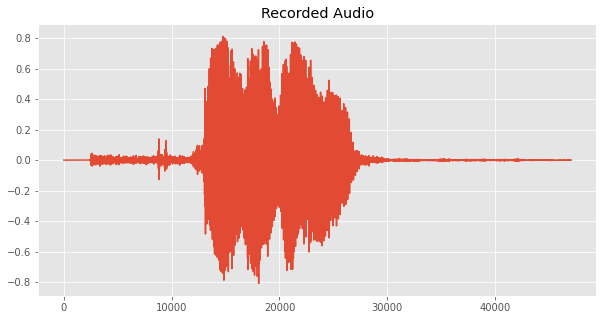

In [24]:
recording_seconds = 3 # seconds of recording
x = record(recording_seconds, SAMPLING_RATE)
plt.figure(figsize=(10,5))
plt.plot(x)
plt.title("Recorded Audio")
plt.show()

In [30]:
IPython.display.Audio(x, rate=SAMPLING_RATE)

## Extract MFCCs from Audio

In [26]:
mfccs = librosa.feature.mfcc(y=x, sr=SAMPLING_RATE,
                                n_mfcc=N_MFCC,
                                n_fft=N_FFT,
                                hop_length=HOP_LEN)
mfccs = dp.normalize_mfcc(mfccs.T) #transpose twice in order to normalize on right axis

## Get PPGs

In [27]:
ppgs = converter.model(mfccs[np.newaxis, :])

In [28]:
predictions = np.argmax(ppgs[0], axis=1)

In [29]:
p_compressed = compress_prediction(predictions, transcriptor)
print("___________________________________")

print(f"|{'Start ms':10}| {'End ms':10} | {'Phoneme':8}|")
print("-----------------------------------")
for tup in p_compressed:
  print(f"|{tup[0]:-8d}  |{tup[1]:-9d}\t|{tup[2]:9}|")
print("-----------------------------------")

___________________________________
|Start ms  | End ms     | Phoneme |
-----------------------------------
|       0  |      150	|sil      |
|     150  |      330	|uw       |
|     330  |      410	|n        |
|     410  |      430	|dh       |
|     430  |      440	|er       |
|     440  |      470	|ih       |
|     470  |      510	|n        |
|     510  |      620	|hh       |
|     620  |      650	|sil      |
|     650  |      680	|ih       |
|     680  |      790	|hh       |
|     790  |      960	|ay       |
|     960  |     1180	|ow       |
|    1180  |     1240	|w        |
|    1240  |     1420	|aa       |
|    1420  |     1530	|r        |
|    1530  |     1730	|ow       |
|    1730  |     1750	|n        |
|    1750  |     1780	|sil      |
|    1780  |     1840	|z        |
|    1840  |     2950	|sil      |
-----------------------------------
